# NB02: The Analytical CHE Window (Updated)

## Imports & definitions

In [1]:
from time import time
from pathlib import Path
from collections.abc import Callable

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import astropy.units as u
import astropy.constants as ct
from astropy.cosmology import WMAP9 as cosmo

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
plt.style.use('./plotstyle.mplstyle')

In [4]:
MASS_U = u.M_sun
PERIOD_U = u.day
AGE_U = u.yr
SMA_U = u.R_sun
RADIUS_U = u.R_sun
TEMP_U = u.K
LUMINOSITY_U = u.Lsun
OMEGA_U = 1 / u.s
TORQUE_U = MASS_U * SMA_U**2 / AGE_U**2
DENSITY_U = u.g / u.cm**3

UOQ_TYPE = float | u.quantity.Quantity
"""Type union of float and astropy.units.quantity.Quantity."""

t_H = cosmo.age(0).to(AGE_U).value

In [5]:
X0 = 0.75
Y0 = 0.25
Z0 = 0.

X_SUN = 0.7 
Z_SUN = 0.017
Y_SUN = 1 - X_SUN - Z_SUN

In [6]:
def fix_unit(var, unit):
    """If a variable is passed without a unit, set it to a specified one."""
    if type(var) != u.quantity.Quantity:
        var *= unit
    else:
        pass
    return var

def p_from_a(a, m, q):
    a = fix_unit(a, SMA_U)
    m = fix_unit(m, MASS_U)
    p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
    p = p.to(PERIOD_U)
    return p

def a_from_p(p, m, q):
    p = fix_unit(p, PERIOD_U)
    m = fix_unit(m, MASS_U)
    a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
    a = a.to(SMA_U)
    return a

def w_from_p(p):
    p = fix_unit(p, PERIOD_U)
    w = 2*np.pi*u.rad / p
    w = w.to(OMEGA_U)
    return w

def p_from_w(w):
    w = fix_unit(w, OMEGA_U)
    p = 2*np.pi*u.rad / w
    p = p.to(PERIOD_U)
    return p

## References

Eggleton, P. P., *Aproximations to the radii of Roche lobes*, 1983, [ApJ, 268, 368](https://ui.adsabs.harvard.edu/abs/1983ApJ...268..368E/abstract).  
Gormaz-Matamala, A. C., Curé, M., Meynet, G., Cuadra, J., Groh, J. H. & Murphy, L. J., *Evolution of massive stars with new hydrodynamic wind models*, 2022, [A&A, 665, 15](https://ui.adsabs.harvard.edu/abs/2022A%26A...665A.133G/abstract).  
Maeder, A., *Physics, Formation and Evolution of Rotating Stars*, Springer (Heidelberg, 2009).  
Marchant, P., Langer, N., Podsiadlowski, P., Tauris, T. M. & Moriya, T. J., *A new route towards merging massive black holes*, 2016, [A&A, 588, 13](https://ui.adsabs.harvard.edu/abs/2016A%26A...588A..50M/abstract).  
Pols, O., *Compact binaries lecture notes, part II*, at https://www.astro.ru.nl/~onnop/education/binaries_utrecht_notes/   
Romagnolo, A., Gormaz-Matamala, A. C. & Belczynski, K., *On the Maximum Black Hole Mass at Solar Metallicity*, 2024, [ApJL, 964, 8](https://ui.adsabs.harvard.edu/abs/2024ApJ...964L..23R/abstract).  
Sanders, A. A. C. & Vink, J. S., *On the nature of massive helium star winds and Wolf-Rayet-type mass-loss*, 2020, [MNRAS, 499, 873](https://ui.adsabs.harvard.edu/abs/2020MNRAS.499..873S/abstract)  
Sanders, A. A. C., Lefever, R. R., Poniatowski, L. G., Ramachandran, V., Sabhahit, G. N. & Vink, J. S., *The temperature dependency of Wolf-Rayet-type mass loss. An exploratory study for winds launched by the hot iron bump*, 2023, [A&A, 670, A83](https://ui.adsabs.harvard.edu/abs/2023A%26A...670A..83S/abstract)  
Tout, C. A., Pols, O. R., Eggleton, P. R. & Han, Z., *Zero-age main-sequence radii and luminosities as analytic functions of mass and metallicity*, 1996, [MNRAS, 281, 257](https://ui.adsabs.harvard.edu/abs/1996MNRAS.281..257T/abstract).

## Wind models

In [7]:
def vink2001_w(m, l, teff, z):
    t_jump = 61.2 + 2.59*(-13.636+0.889*np.log10(z/Z_SUN))
    dt_jump = 100
    
    if teff > 27.5e3:
        a = 1
    elif teff < 22.5e3:
        a = 0
    else:
        if teff > t_jump+dt_jump:
            a = 1
        elif teff < t_jump-dt_jump:
            a = 0
        else:
            a = (teff-(t_jump-dt_jump))/(2*dt_jump)
    
    if a > 0:
        vinf_div_vesc = 2.6*(z/Z_SUN)**0.13
        log_mdot = (-6.697
                    +2.194*np.log10(l/1e5)
                    -1.313*np.log10(m/30)
                    -1.226*np.log10(vinf_div_vesc/2)
                    +0.933*np.log10(teff/4e4)
                    -10.92*np.log10(teff/4e4)**2
                    +0.85*np.log10(z/Z_SUN))
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
    
    if a < 1:
        vinf_div_vesc = 1.3*(z/Z_SUN)**0.13
        log_mdot = (-6.688
                    +2.210*np.log10(l/1e5)
                    -1.339*np.log10(m/30)
                    -1.601*np.log10(vinf_div_vesc/2)
                    +1.07*np.log10(teff/4e4)
                    +0.85*np.log10(z/Z_SUN))
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0

    w = a*mdot1 + (1-a)*mdot2
    log_abs_mdot = np.log10(np.abs(w))
    return log_abs_mdot

def sander2020_l_w(l, z):
    logz = np.log10(z/Z_SUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 1e-12
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    log_abs_mdot = np.log10(np.abs(w))
    return log_abs_mdot

In [8]:
def fiducial_wind_scheme(m, l, teff, r, z, x):
    x0 = 0.6
    dx = 0.3    
    
    ms_log_abs_mdot = vink2001_w(m, l, teff, z)
    wr_log_abs_mdot = sander2020_l_w(l, z)
    
    if x > x0:
        ms_w = 1.
    elif x > x0 - dx:
        ms_w = -(x0 - dx - x)/dx
    else:
        ms_w = 0.
        
    log_abs_mdot = ms_w * ms_log_abs_mdot + (1-ms_w) * wr_log_abs_mdot
    return log_abs_mdot

## Quantity definitions

We adopt the mass-luminosity relations (MLRs) from Gräfener et al. (2011) for the MS and the HeMS.

In [9]:
def grafener2011_ms_mlr(m, x):
    m = fix_unit(m, MASS_U).to(u.Msun).value
    FF1 = [2.875, -3.966, 2.496, 2.652, -0.310, -0.511]
    FF2 = [1.967, -2.943, 3.755, 1.206, -0.727, -0.026]
    FF3 = [3.862, -2.486, 1.527, 1.247, -0.076, -0.183]
    
    FF = FF1
    log_l = (FF[0] + FF[1]*x
             + (FF[2] + FF[3]*x) * np.log10(m)
             + (FF[4] + FF[5]*x) * np.log10(m)**2)
    if log_l > 6.5:
        FF = FF3
        log_l = (FF[0] + FF[1]*x
             + (FF[2] + FF[3]*x) * np.log10(m)
             + (FF[4] + FF[5]*x) * np.log10(m)**2)
    return 10.**log_l * u.Lsun

def grafener2011_hems_mlr(m):
    m = fix_unit(m, MASS_U).to(u.Msun).value
    FF = [3.826, 1.619, -0.099] # 8
    log_l = FF[0] + FF[1]*np.log10(m) + FF[2]*np.log10(m)**2
    return 10.**log_l * u.Lsun

We adopt the MS mass-radius relation (MRR) from Tout et al. (1996).

In [10]:
class ToutMassRadiusRelation:
    """Mass-radius relation at ZAMS from Tout et al. (1996)."""

    def __init__(self, metallicity=Z_SUN):
        self.metallicity = metallicity
        self.fit_params = None
        self.coefficients = None
        self._load_fit_params()
        self._set_coefficients()

    def _load_fit_params(self):
        self.fit_params = np.genfromtxt('tout_zams_mrr', skip_header=True, usecols=(1, 2, 3, 4, 5))
    
    def _set_coefficients(self):
        met_factor = np.array([np.log10(self.metallicity/Z_SUN)**i for i in range(5)])
        met_factor = np.tile(met_factor, (10, 1))
        met_factor[-2] = np.ones(5)/5
        self.coefficients = self.fit_params * met_factor
        self.coefficients = np.sum(self.coefficients, axis=1)

    def radius(self, m):
        m = fix_unit(m, MASS_U).to(u.Msun).value
        indices = np.array([2.5, 6.5, 11, 19, 19.5, 0, 2, 8.5, 18.5, 19.5])
        terms = self.coefficients * m**indices
        radius = np.sum(terms[:5]) / np.sum(terms[5:])
        return radius * u.Rsun
    
    
def tout1996_ms_mrr(m, z):
    m = fix_unit(m, MASS_U).to(u.Msun).value
    mrr = ToutMassRadiusRelation(z)
    r = mrr.radius(m)
    return r

We assume a constant nuclear burning rate in the MS, i.e., the central hydrogen abundance evolves linearly over time.

In [11]:
def get_x_y(z):
    x = (X_SUN - X0)/(Z_SUN - Z0) * (z - Z0) + X0
    x = max(x, 0.)
    y = 1 - x - z
    return x, y

$$
\begin{align*}
X(t) = X_0 + \frac{X_f-X_0}{t_{ms}-t_0}(t-t_0) - \frac{X-X_s(t)}{}
\end{align*}$$

In [12]:
class HomogeneousStar:
    
    def __init__(
        self, 
        z_div_zsun: UOQ_TYPE, 
        m0: UOQ_TYPE, 
        p_orb0: UOQ_TYPE, 
        q0: float, 
        w0: UOQ_TYPE,
        ms_mlr: Callable[[float, float], float], 
        hems_mlr: Callable[[float], float], 
        ms_mrr: Callable[[float, float], float], 
        wind_scheme: Callable[[float, float, float, float, float, float], float],
        dm: UOQ_TYPE = 1*u.Msun,
        force_tidal_sync: bool = True,
        tide_mode: str = 'radiative',
        luminosity_mode: str = 'interpolate',
        l_interp_x0: float = 0.,
        l_interp_dx: float = 1.,
        f_core_mass: float = 0.8,
        f_core_radius: float = 0.8,
        rhoc: UOQ_TYPE = 1.,
        rhob_div_rhoc = 0.1,
        che_min_y_ratio = 0.7,
        mixing_attenuation: float = 10.,
        verbose: bool = True
        ) -> None:
        ## User-set parameters
        self.z = Z_SUN * z_div_zsun
        self.z_div_zsun = z_div_zsun
        self.m0 = fix_unit(m0, MASS_U)
        self.p_orb0 = fix_unit(p_orb0, PERIOD_U)
        self.q0 = q0
        self.w0 = fix_unit(w0, OMEGA_U)
        self.a0 = a_from_p(self.p_orb0, self.m0, self.q0)
        self.ms_mlr = ms_mlr
        self.hems_mlr = hems_mlr
        self.ms_mrr = ms_mrr
        self.wind_scheme = wind_scheme
        self.force_tidal_sync = force_tidal_sync
        self.tide_mode = tide_mode
        self.luminosity_mode = luminosity_mode
        self.dm = fix_unit(dm, MASS_U)
        self.l_interp_x0 = l_interp_x0
        self.l_interp_dx = l_interp_dx
        self.f_core_mass = f_core_mass
        self.f_core_radius = f_core_radius
        self.rhoc = fix_unit(rhoc, DENSITY_U) # core-envelope boundary
        self.rhob_div_rhoc = rhob_div_rhoc
        self.che_min_y_ratio = che_min_y_ratio
        self.mixing_attenuation = mixing_attenuation
        self.verbose = verbose
        
        ## Stellar properties
        self.center_x0, self.center_y0 = get_x_y(self.z)
        self.surface_x0 = self.center_x0
        self.surface_y0 = self.center_y0
        self.l0 = self._get_l(self.m0, self.surface_x0)
        self.r0 = self._get_r(self.m0)
        self.teff0 = self._get_teff(self.l0, self.r0)
        
        ## Constants
        self.delta_4h_he4 = 0.007
        self.f_turb = 1.
               
        ## Properties over time
        ### Set by calling integration.
        self.t = list()
        self.m = list()
        self.q = list()
        self.a = list()
        self.p_orb = list()
        self.w = list()
        self.p_spin = list()
        self.l = list()
        self.r = list()
        self.teff = list()
        self.center_x = list()
        self.center_y = list()
        self.surface_x = list()
        self.surface_y = list()
        self.g_e = list()
        self.log_abs_mdot = list()
        self.t_ms = list()
        self.t_mix = list()
        self.torque = list()
        
    @property
    def tide_mode(self):
        return self._tide_mode
    
    @tide_mode.setter
    def tide_mode(self, tide_mode):
        tide_mode_options = ['radiative', 'turbulent']
        if tide_mode in tide_mode_options:
            self._tide_mode = tide_mode
        else:
            raise ValueError(f'tide_mode must be one of {tide_mode_options}')   
     
    # TIMESCALES    
    def _get_t_ms(self, m: UOQ_TYPE, l: UOQ_TYPE, x: float) -> float:
        """Main Sequence lifetime."""
        m = fix_unit(m, MASS_U)
        l = fix_unit(l, LUMINOSITY_U)
        t_ms = self.f_core_mass * x * self.delta_4h_he4 * m * ct.c**2 / l
        return t_ms.to(AGE_U).value
        
    def _get_t_kh(self, m: UOQ_TYPE, l: UOQ_TYPE, r: UOQ_TYPE) -> float:
        """Thermal timescale."""
        m = fix_unit(m, MASS_U)
        l = fix_unit(l, LUMINOSITY_U)
        r = fix_unit(r, RADIUS_U)
        t_kh = ct.G * m**2 / (2*r*l)  
        return t_kh.to(AGE_U).value
    
    def _get_t_es(self, m: UOQ_TYPE, l: UOQ_TYPE, r: UOQ_TYPE, w: UOQ_TYPE) -> float:
        """Eddington-Sweet timescale."""
        m = fix_unit(m, MASS_U)
        l = fix_unit(l, LUMINOSITY_U)
        r = fix_unit(r, RADIUS_U)
        w = fix_unit(w, OMEGA_U)
        t_kh = self._get_t_kh(m, l, r) * AGE_U
        t_es = t_kh * ct.G * m / (w**2  * r**3)
        return t_es.to(AGE_U).value
    
    def _get_t_sync_turb(self, m: UOQ_TYPE, r: UOQ_TYPE, a: UOQ_TYPE, q: float) -> float:
        """Timescale for tidal synchronization through turbulent viscosity."""
        m = fix_unit(m, MASS_U)
        r = fix_unit(r, RADIUS_U)
        a = fix_unit(a, SMA_U)
        t_sync_turb = self.f_turb * q**-2 * (r/a)**-6 * u.yr
        return t_sync_turb.to(AGE_U).value
    
    #TO-DO: implement radiative damping synchronization timescale
    def _get_t_sync_rad(self, m: UOQ_TYPE, r: UOQ_TYPE, a: UOQ_TYPE, q: float) -> float:
        """Timescale for tidal synchronization through radiative damping.
        
        Warning
        -------
        Not implemented yet. For now returns the turbulent viscosity 
        synchronization timescale.
        """
        
        m = fix_unit(m, MASS_U)
        r = fix_unit(r, RADIUS_U)
        a = fix_unit(a, SMA_U)
        t_sync_rad = self._get_t_sync_turb(m, r, a, q)
        return t_sync_rad
    
    def _get_t_mix(self, m: UOQ_TYPE, r: UOQ_TYPE, l: UOQ_TYPE, w: UOQ_TYPE, a: UOQ_TYPE, 
                  q: float) -> float:
        """Mixing timescale.
        
        If tidal synchronization is set to forced, the mixing timescale 
        is the sum of the synchronization and Eddington-Sweet timescales,
        otherwise it is just the Eddington-Sweet timescale.
        """
        
        m = fix_unit(m, MASS_U)
        l = fix_unit(l, LUMINOSITY_U)
        r = fix_unit(r, RADIUS_U)
        w = fix_unit(w, OMEGA_U)
        a = fix_unit(a, SMA_U)
        
        if self.force_tidal_sync:    
            if self.tide_mode == 'radiative':
                t_sync = self._get_t_sync_rad(m, r, a, q)
            elif self.tide_mode == 'turbulent':
                t_sync = self._get_t_sync_turb(m, r, a, q)
        else:
            t_sync = 0.
        
        t_es = self._get_t_es(m, l, r, w)
        t_mix = t_sync + t_es
        
        return t_mix
    
    # BINARY GEOMETRY
    def eggleton1983_rl1_radius(self, a: UOQ_TYPE, q: float) -> float:
        """Primary Roche-lobe volume-equivalent radius."""
        a = fix_unit(a, SMA_U)
        r_rl1 = 0.49 * q**(2/3) / (0.6 * q**(2/3) + np.log(1 + q**(1/3))) * a
        return r_rl1.to(RADIUS_U).value
    
    def eggleton1983_rl2_radius(self, a: UOQ_TYPE, q: float) -> float:
        """Secondary Roche-lobe volume-equivalent radius."""
        a = fix_unit(a, SMA_U)
        Q = 1/q
        r_rl2 = self.eggleton_rl1_radius(a, Q)
        return r_rl2
    
    def marchant2016_l2_radius(self, a: UOQ_TYPE, q: float) -> float:
        """L2 volume-equivalent radius."""
        a = fix_unit(a, SMA_U)
        r_rl2 = self.eggleton1983_rl2_radius(a, q) * SMA_U
        r_l2 = (1 + 0.299*np.arctan(1.84 * q**0.397)) * r_rl2
        return r_l2.to(SMA_U).value
    
    # TIDAL SYNCHRONIZATION
    def _get_turbulent_viscosity_torque(self):
        """Tidal synchronization torque through turbulent viscosity (convective envelopes).
        
        Warning
        -------
        Not implemented.
        """
        
        return 0.
    
    def _get_radiative_damping_torque(self, m, q, r, w_spin, a, beta2=1.):
        """Tidal synchronization torque through radiative damping (radiative envelopes). 
        
        Assumes e=0, so d=2*a always. Quantities labeled _c are evaluated
        at the center, _b at the convective core boundary.
        """
        
        m = fix_unit(m, MASS_U)
        r = fix_unit(r, RADIUS_U)
        w_spin = fix_unit(w_spin, OMEGA_U)
        a = fix_unit(a, SMA_U)
        
        m_b = self.f_core_mass * m
        r_b = self.f_core_radius * r
        d = 2*a
        p = p_from_a(a, m, q)
        w_orb = (2*np.pi / p).to(OMEGA_U)
        sc = 2 * np.abs(w_spin - w_orb) * np.sqrt(r_b**3 / ct.G / m_b)
        
        rho_b = self.rhoc * self.rhob_div_rhoc
        mean_rho_b = m_b / (4/3 * np.pi * r_b**3) * (u.Msun/u.Rsun**3).to(u.g/u.cm**3)
        rho_ratio = rho_b/mean_rho_b
        mass_term = ct.G * (q*m)**2 / r_b
        
        torque = beta2 * mass_term * (r_b/d)**6 * sc**(8/3) * rho_ratio * (1 - rho_ratio)**2
        sign = np.sign(w_orb-w_spin)
        return sign * torque.to(TORQUE_U).value    
        
    def _get_tidal_torque(self, m, q, r, w_spin, a):
        if self.force_tidal_sync:
            torque = 0.
        else:
            if self.tide_mode == 'radiative':
                torque = self._get_radiative_damping_torque(m, q, r, w_spin, a)
            elif self.tide_mode == 'turbulent':
                torque = self._get_turbulent_viscosity_torque()
        return torque
        
        
    # INTEGRATION
    def _get_dt(self, log_abs_mdot):
        abs_mdot = 10.**log_abs_mdot * MASS_U/AGE_U
        dt_to_lose_dm = self.dm / abs_mdot
        dt = dt_to_lose_dm.to(AGE_U).value
        dt = min(1e5, dt)
        return dt
        
    def _get_l(self, m, x):
        m = fix_unit(m, MASS_U)
        
        ms_l = self.ms_mlr(m, x)
        hems_l = self.hems_mlr(m)
        
        if x < self.l_interp_x0:
            ms_w = 0.
        elif x < self.l_interp_x0 + self.l_interp_dx:
            ms_w = (x - self.l_interp_x0) / self.l_interp_dx
        else:
            ms_w = 1.
            
        l = ms_w * ms_l + (1 - ms_w) * hems_l
        
        return l.to(LUMINOSITY_U).value
    
    def _get_r(self, m):
        m = fix_unit(m, MASS_U)
        r = self.ms_mrr(m, self.z)
        return r.to(RADIUS_U).value
    
    def _get_teff(self, l, r):
        l = fix_unit(l, LUMINOSITY_U)
        r = fix_unit(r, RADIUS_U)
        t_eff4 = l / (4*np.pi * r**2 * ct.sigma_sb)
        t_eff = (t_eff4)**0.25
        return t_eff.to(TEMP_U).value
        
    def _get_moment_of_inertia(self, m, r):
        m = fix_unit(m, MASS_U)
        r = fix_unit(r, RADIUS_U)
        k = 0.04 *(m/(10*u.Msun))**-0.1
        i = k * m * r**2
        return i.to(MASS_U * RADIUS_U**2).value
    
    def _get_classical_eddington_factor(self, m, l, x):
        """Electron-scattering only Eddington factor."""
        m = fix_unit(m, MASS_U)
        l = fix_unit(l, LUMINOSITY_U)
        g_e = 10.**-4.813 * (1+x) * (l/u.Lsun) * (m/u.Msun)**-1
        return g_e.value
        
    def integrate(self, t_stop=np.inf):
        header = (
            f"{'Time (yr)':>10} | {'Mass (Msun)':>11} | {'q':>5} | {'a (Rsun)':>11} | "
            f"{'P_orb (d)':>10} | {'w (1/s)':>10} | {'P_spin (d)':>11} | {'L (Lsun)':>10} | "
            f"{'R (Rsun)':>10} | {'Teff (K)':>10} | {'X_c':>5} | {'Y_c':>5} | {'X_s':>5} | {'Y_s':>5} | {'g_e':>10} |"
            f"{ 'log_abs_mdot':>10} | {'t_ms (yr)':>10} | {'t_mix (yr)':>10} | {'torque (Msun Rsun2 yr-2)'}"
            )
        
        G = ct.G.to(SMA_U**3 / MASS_U / AGE_U**2).value # rsun3 msun yr-1   
        t = 0.
        m = self.m0.value # msun
        q = self.q0
        a = self.a0.value # rsun
        p_orb = self.p_orb0.value # d
        w = self.w0.value # s-1
        p_spin = 2*np.pi/w * u.s.to(u.d)
        l = self.l0 # lsun
        r = self.r0 # rsun
        teff = self.teff0 # K
        center_x = self.center_x0
        center_y = self.center_y0
        surface_x = self.surface_x0
        surface_y = self.surface_y0
        g_e = self._get_classical_eddington_factor(m, l, surface_x)
        log_abs_mdot = self.wind_scheme(m, l, teff, r, self.z, surface_x)
        t_ms = self._get_t_ms(m, l, center_x) 
        t_mix = self._get_t_mix(m, r, l, w, a, q)
        torque = self._get_tidal_torque(m, q, r, w, a)
        
        if self.force_tidal_sync:
            w = 2*np.pi / (p_orb * u.d.to(u.s))
            p_spin = p_orb
        
        self.t.append(t)
        self.m.append(m)
        self.q.append(q)
        self.a.append(a)
        self.p_orb.append(p_orb)
        self.w.append(w)
        self.p_spin.append(p_spin)
        self.l.append(l)
        self.r.append(r)
        self.teff.append(teff)
        self.center_x.append(center_x)
        self.center_y.append(center_y)
        self.surface_x.append(surface_x)
        self.surface_y.append(surface_y) 
        self.g_e.append(g_e)
        self.log_abs_mdot.append(log_abs_mdot)
        self.torque.append(torque)
        
        if self.verbose:
            print('\n')
            print('----------------------------------------')
            print(header)
            print(
                    f"{t:10.2e} | {m:11.2f} | {q:5.2f} | {a:11.2f} | "
                    f"{p_orb:10.2f} | {w:10.2e} | {p_spin:11.2f} | {l:10.2f} | "
                    f"{r:10.2f} | {teff:10.2f} | {center_x:5.2f} | {center_y:5.2f} | "
                    f"{surface_x:5.2f} | {surface_y:5.2f} | {g_e:10.2e} | {log_abs_mdot:10.2e} | "
                    f"{t_ms:10.2e} | {t_mix:10.2e} | {torque:10.2e}"
                    )
            print('\n')
            
        stop = False
        counter = 1
        x_mixed_into_core = 0
        while not stop:     
            log_abs_mdot = self.wind_scheme(m, l, teff, r, self.z, surface_x)
            dt = self._get_dt(log_abs_mdot)           
            #if t + dt > t_ms:
            #    dt = t_ms - t         
            #    stop = True
            #    print(f'Hit stop condition: t+dt ({t+dt/1e6} Myr) > t_ms ({t_ms/1e6} Myr)')
            
            dm = - 10.**log_abs_mdot * dt
            dq = 0.
            
            j_unit = m * np.sqrt(G*m*a)
            moment_of_inertia = self._get_moment_of_inertia(m, r)
            torque = self._get_tidal_torque(m, q, r, w, a)
            
            
            da_div_a = -dm/m - 8*torque/j_unit * dt
            dw  =  w*dm/m + torque/moment_of_inertia *dt
            dcx_div_cx = -dt/(t_ms-t) + 1/self.mixing_attenuation * (surface_x - center_x) * dt/t_mix
            dsx_div_sx = -(surface_x - center_x) * dt/t_mix
            
            x_mixed_into_core += 1/self.mixing_attenuation * (surface_x - center_x) * dt/t_mix
            
            t += dt
            m += dm
            q += dq
            a += a*da_div_a
            p_orb = p_from_a(a, m, q).value
            w += dw
            if self.force_tidal_sync:
                w = 2*np.pi / (p_orb * u.d.to(u.s))
            p_spin = 2*np.pi/max(w, 1e-10) * u.s.to(u.d)
            l = self._get_l(m, surface_x)
            r = r
            teff = self._get_teff(l, r)
            center_x += center_x*dcx_div_cx
            center_y = 1. - center_x - self.z
            surface_x += surface_x*dsx_div_sx
            surface_y = 1. - surface_x - self.z
            g_e = self._get_classical_eddington_factor(m, l, surface_x)
            log_abs_mdot = self.wind_scheme(m, l, teff, r, self.z, surface_x)
            t_ms = self._get_t_ms(self.m0, self.l0, self.center_x0+x_mixed_into_core)   
            t_mix = self._get_t_mix(m, r, l, w, a, q)
            
            if center_x <= 0.01:
                center_x = 0.01
            
            self.t.append(t)
            self.m.append(m)
            self.q.append(q)
            self.a.append(a)
            self.p_orb.append(p_orb)
            self.w.append(w)
            self.p_spin.append(p_spin)
            self.l.append(l)
            self.r.append(r)
            self.teff.append(teff)
            self.center_x.append(center_x)
            self.center_y.append(center_y)
            self.surface_x.append(surface_x)
            self.surface_y.append(surface_y) 
            self.g_e.append(g_e)
            self.log_abs_mdot.append(log_abs_mdot)
            self.t_ms.append(t_ms)
            self.t_mix.append(t_mix)
            self.torque.append(torque)

            if self.verbose:                           
                if not counter%10:
                    print('\n')
                    print('----------------------------------------')
                    print(header)
                
                print(
                    f"{t:10.2e} | {m:11.2f} | {q:5.2f} | {a:11.2f} | "
                    f"{p_orb:10.2f} | {w:10.2e} | {p_spin:11.2f} | {l:10.2f} | "
                    f"{r:10.2f} | {teff:10.2f} | {center_x:5.2f} | {center_y:5.2f} | "
                    f"{surface_x:5.2f} | {surface_y:5.2f} | {g_e:10.2e} | {log_abs_mdot:10.2e} | "
                    f"{t_ms:10.2e} | {t_mix:10.2e} | {torque:10.2e}"
                    )
            
            if surface_y/center_y <= self.che_min_y_ratio and center_x > 0.1:
                stop = True
                print(f'Hit stop condition: surface_y/center_y ({surface_y/center_y}) < {self.che_min_y_ratio}')
                
            if t >= t_stop:
                stop = True
                print(f'Hit stop condition: t ({t/1e6} Myr) > {t_stop/1e6} Myr')
                
            #if t >= t_ms:
            #    stop=True
            #    print(f'Hit stop condition: t ({t/1e6} Myr) >= t_ms ({t_ms/1e6} Myr)')
            
            if center_x <= 0.01:
                stop = True
                print(f'Hit stop condition: center_x ({center_x}) <= 0.01')
                
            if m <= 0.:
                stop = True
                print(f'Hit stop condition: m ({m} Msun) <= 0')
                
            counter += 1
            

## Analytical CHE window step-by-step plot

In [13]:
from scipy.optimize import fmin

In [14]:
def get_t_gw(m: UOQ_TYPE, a: UOQ_TYPE, q: float) -> float:
    """Gravitational decay timescale."""
    m = fix_unit(m, MASS_U)
    a = fix_unit(a, SMA_U)
    b = 5 * ct.c**5 / 256 / ct.G**3
    t_gw = b * a**4 / (m**3 * q * (1+q))
    return t_gw.to(AGE_U).value

def get_t_kh(m: UOQ_TYPE, l: UOQ_TYPE, r: UOQ_TYPE) -> float:
    """Thermal timescale."""
    m = fix_unit(m, MASS_U)
    l = fix_unit(l, LUMINOSITY_U)
    r = fix_unit(r, RADIUS_U)
    t_kh = ct.G * m**2 / (2*r*l)  
    return t_kh.to(AGE_U).value

def get_t_es(m: UOQ_TYPE, l: UOQ_TYPE, r: UOQ_TYPE, w: UOQ_TYPE) -> float:
    """Eddington-Sweet timescale."""
    m = fix_unit(m, MASS_U)
    l = fix_unit(l, LUMINOSITY_U)
    r = fix_unit(r, RADIUS_U)
    w = fix_unit(w, OMEGA_U)
    t_kh = get_t_kh(m, l, r) * AGE_U
    t_es = t_kh * ct.G * m / (w**2  * r**3)
    return t_es.to(AGE_U).value

def get_t_ms(m: UOQ_TYPE, l: UOQ_TYPE, x: float) -> float:
        """Main Sequence lifetime."""
        m = fix_unit(m, MASS_U)
        l = fix_unit(l, LUMINOSITY_U)
        t_ms = 0.05 * x * 0.007 * m * ct.c**2 / l
        return t_ms.to(AGE_U).value

In [15]:
def eggleton_rl1_radius(a, q):
    """Primary Roche lobe-equivalent radius, from Eggletion (1983)."""
    a = fix_unit(a, SMA_U)
    rl1 = 0.49 * q**(2/3) / (0.6*q**(2/3) + np.log(1 + q**(1/3))) * a
    rl1 = rl1.to(RADIUS_U)
    return rl1    

def eggleton_rl2_radius(a, q):
    """Secondary Roche lobe-equivalent radius, from Eggletion (1983)."""
    a = fix_unit(a, SMA_U)
    Q = 1/q
    rl2 = 0.49 * Q**(2/3) / (0.6*Q**(2/3) + np.log(1 + Q**(1/3))) * a
    rl2 = rl2.to(RADIUS_U)
    return rl2 

def marchant_l2_radius(a, q):
    """L2-equivalent radius, from Marchant et al. (2016)."""
    a = fix_unit(a, SMA_U)
    rl2 = eggleton_rl2_radius(a, q)
    relative_l2_radius = 0.299 * np.arctan(1.84 * q**0.397)
    l2_radius = (1 + relative_l2_radius) * rl2
    return l2_radius 

In [16]:
z = Z_SUN/10
plot_masses = np.logspace(np.log10(300), np.log10(3) ,10)

In [18]:
che_loc = np.zeros((plot_masses.shape[0], 2))
che_star_inst = list()

p_res = 0.1
last_p = 1
che_min_y_ratio = 0.8

last_p -= p_res
search = True
for i, m in enumerate(plot_masses):
    while search:
        p = last_p + p_res
        star = HomogeneousStar(
                            z_div_zsun=z/Z_SUN,
                            m0=m,
                            p_orb0=p,
                            q0=1,
                            w0=2*np.pi/(p*u.d.to(u.s)),
                            ms_mlr=grafener2011_ms_mlr,
                            hems_mlr=grafener2011_hems_mlr,
                            ms_mrr=tout1996_ms_mrr,
                            wind_scheme=fiducial_wind_scheme,
                            force_tidal_sync=True,
                            dm=0.001,
                            mixing_attenuation=10.,
                            che_min_y_ratio=che_min_y_ratio,
                            verbose=False
                        )
        
    
        t_es = get_t_es(m, star.l0, star.r0, 2*np.pi/(p*u.d.to(u.s)))
        t_ms = get_t_ms(m, star.l0, star.center_x0)
        if t_es > t_ms:
            print(f'm={m}, p={p} was never CHE \n')
            search = False
            break
        
        star.integrate()
        che_star_inst.append(star)
        y_ratio = star.surface_y[-1]/star.center_y[-1]
        x_center = star.center_x[-1]
        if x_center > 0.1:
            print(f'm={m}, p={p} is not CHE \n')
            break
        else:
            print(f'm={m}, p={p} is CHE')
            last_p = p
            continue     
    
    if not search:
        mrr = ToutMassRadiusRelation(metallicity=z)
        r = mrr.radius(m).value
        x, y = get_x_y(z)
        l = grafener2011_ms_mlr(m, x).value
        def f_to_min(p):
            w = 2*np.pi / (p*u.d.to(u.s))
            w = w[0]
            t_es = get_t_es(m, l, r, w)
            t_ms = get_t_ms(m, l, x)
            return np.abs(t_es - t_ms)
        p = fmin(f_to_min, x0=1, disp=0)[0]
               
    che_loc[i, 0] = m
    che_loc[i, 1] = p
che_loc_01zsun = che_loc

import pickle as pkl
with open('01zsun_stars.pkl', 'wb') as f:
    pkl.dump(che_star_inst, f)
np.save('che_loc_01zsun.npy', che_loc_01zsun)

KeyboardInterrupt: 

In [ ]:
che_loc

array([[300.        ,   1.82610757],
       [179.8452751 ,   2.1844855 ],
       [107.81440991,   2.36924442],
       [ 64.6330407 ,   2.36632457],
       [ 38.74648995,   2.22911777],
       [ 23.22791048,   2.02967322],
       [ 13.9247665 ,   1.8222194 ],
       [  8.34767821,   1.63533022],
       [  5.00430161,   1.47902143],
       [  3.        ,   1.35510848]])

: 

: 

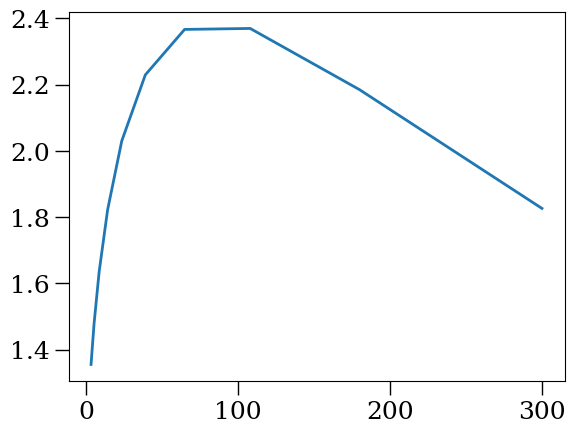

: 

In [ ]:
plt.plot(che_loc[:,0], che_loc[:,1])

In [ ]:
import pickle as pkl
pkl.dump(che_star_inst '01zsun_stars.pkl')

: 

In [ ]:
gw_loc = np.zeros((plot_masses.shape[0], 2))

for i, m in enumerate(plot_masses):
    def f_to_min(a):
        t_gw = get_t_gw(m, a, 1)
        return np.abs(t_gw - t_H)
    a = fmin(f_to_min, x0=50, disp=0)
    p = p_from_a(a, m, 1)[0]
    gw_loc[i, 0] = m
    gw_loc[i, 1] = p.value

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


: 

In [ ]:
che_loc

array([[ 40.        ,   2.7       ],
       [ 50.33048361,   2.3       ],
       [ 63.32893951,   2.        ],
       [ 79.68440379,   1.8       ],
       [100.26386447,   1.6       ],
       [126.15821968,   1.4       ],
       [158.7401052 ,   1.2       ],
       [199.73665656,   1.1       ],
       [251.32106298,   1.        ],
       [316.22776602,   0.9       ]])

: 

In [ ]:
np.save('02zsun_che_loc.npy', che_loc)

: 